# Starter Notebook

Install and import required libraries

In [26]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [27]:
!pip install scikit-learn
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from tqdm import tqdm
import evaluate
from transformers import EarlyStoppingCallback
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [28]:
# Disable wandb reporting
os.environ["WANDB_DISABLED"] = "true"

## Load Tokenizer and Preprocess Data

In [29]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    # Use max_length=256 for better coverage of text content
    tokenized = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=256)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [30]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [31]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [32]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [33]:
# Minimal LoRA configuration

# PEFT Config
#peft_config = LoraConfig(
#    r=10,
#    lora_alpha=32,
#    lora_dropout=0.1,
#    bias='none',
#    target_modules=['query','fc1','fc2','value','out_proj'],
#    task_type="SEQ_CLS",
#)

# Enhanced LoRA configuration with layer-specific settings
peft_config = LoraConfig(
    r=4,                       # Reduce rank to 4 
    lora_alpha=16,             # Set alpha to 16 (4x rank)
    lora_dropout=0.05,         # Lower dropout slightly for stability
    bias='none',               # Keep bias as 'none'
    # Be selective about target modules
    target_modules=["query", "value"], 
    task_type="SEQ_CLS",
    modules_to_save=["classifier"]  # Fine-tune the classifier head
)

In [34]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [35]:
# print("Trainable parameters:")
# for name, param in peft_model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [36]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 741,124 || all params: 125,389,832 || trainable%: 0.5911


## Training Setup

In [37]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [38]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_steps=100,
    learning_rate=4e-4,                    # Higher learning rate 
    per_device_train_batch_size=32,        # Larger batch size
    per_device_eval_batch_size=64,
    num_train_epochs=10,                   # More epochs
    weight_decay=0.01,
    lr_scheduler_type="cosine",            # Cosine scheduler
    warmup_ratio=0.1,
    optim="adamw_torch",
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",      
    greater_is_better=True,
    gradient_accumulation_steps=2          # Effectively doubles batch size
)
# Add this before defining the get_trainer function
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

def get_trainer(model):
      return Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
          callbacks=[early_stopping],  # Add early stopping
      )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


### Start Training

In [39]:
peft_lora_finetuning_trainer = get_trainer(peft_model)
result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.219700,0.230235,0.914062
2,0.183900,0.213790,0.931250
3,0.169100,0.197892,0.939063
4,0.158400,0.179215,0.937500
5,0.147700,0.172985,0.940625
6,0.144300,0.170030,0.945312
7,0.126700,0.177117,0.943750
8,0.119100,0.173924,0.948438
9,0.118200,0.173496,0.951562


/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/rp4216/.local/lib/python3.9/site-packages/torch/nn/parallel/_f

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [40]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


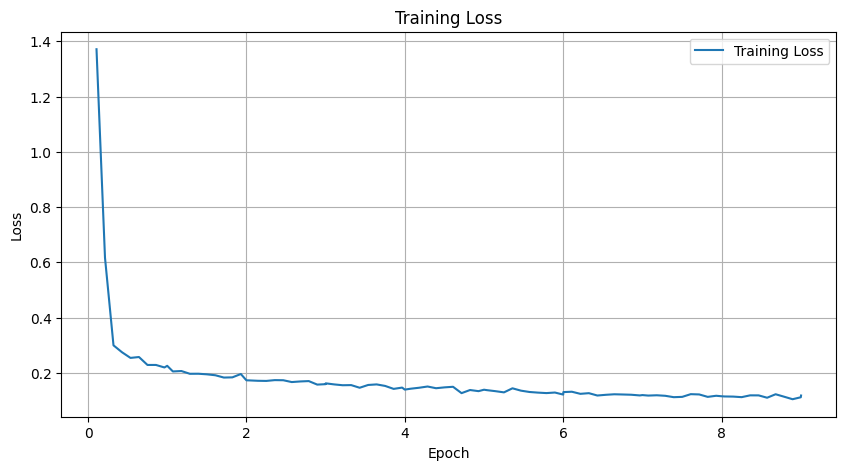

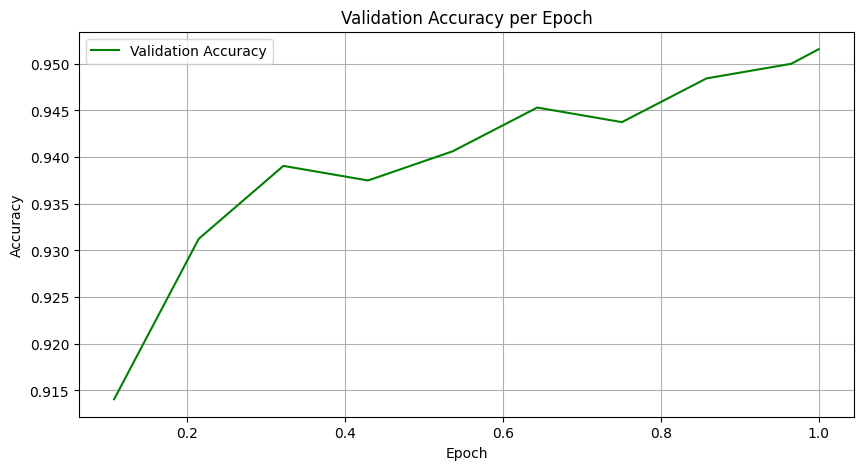

In [42]:
import matplotlib.pyplot as plt

# Extract metrics from trainer log history
logs = peft_lora_finetuning_trainer.state.log_history

# Initialize lists to store data
epochs, train_loss, val_loss, val_acc = [], [], [], []

# Populate the lists
for log in logs:
    if 'epoch' in log:
        epochs.append(log['epoch'])
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            val_loss.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            val_acc.append(log['eval_accuracy'])

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(val_acc)], val_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
# def classify(model, tokenizer, text):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
#     output = model(**inputs)

#     prediction = output.logits.argmax(dim=-1).item()

#     print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
#     return id2label[prediction]

In [44]:
# classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
# classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")

### Run Inference on eval_dataset

In [45]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [46]:
# Check evaluation accuracy
#_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 32, data_collator)

100%|██████████| 20/20 [00:02<00:00,  9.10it/s]

Evaluation Metric: {'accuracy': 0.9515625}


### Run Inference on unlabelled dataset

In [50]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])

Map: 100%|██████████| 8000/8000 [00:05<00:00, 1348.73 examples/s]


In [51]:
# Run inference and save predictions
#preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
# When running on test data
preds = evaluate_model(peft_model, test_dataset, False, 32, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 250/250 [00:26<00:00,  9.52it/s]

Inference complete. Predictions saved to inference_output.csv
